<a href="https://colab.research.google.com/github/NilotpalMaitra/Machine-learning/blob/main/Imagepipelineintern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image Generation and Object Replacement using Stable diffusion 3.5t**

**Author: Nilotpal Maitra
Date: 21 December 2023**

In [3]:
!pip install torch torchvision torchaudio

In [4]:
!pip install opencv-python matplotlib

In [5]:
!pip install transformers diffusers accelerate safetensors segment-anything

In [6]:
!pip install --upgrade jax jaxlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33


In [7]:
import torch
import cv2
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, AutoPipelineForInpainting
from diffusers import StableDiffusionInpaintPipeline
from transformers import pipeline
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import numpy as np
from PIL import Image
import requests
from io import BytesIO

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-12-21 08:02:34--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.124, 108.157.254.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   190MB/s    in 11s     

2024-12-21 08:02:46 (214 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [10]:
def load_sam_model():#Loads the SAM model for automatic mask generation and moves it to the appropriate device (GPU or CPU).
    """
    Loading the Segment Anything Model (SAM) for automatic mask generation
    """
    sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
    sam.to(device)
    mask_generator = SamAutomaticMaskGenerator(sam)
    return mask_generator


In [16]:
def load_sd_model():#Loads the Stable Diffusion inpainting pipeline for object replacement, setting it to use 16-bit floating-point precision for efficiency.
    """
    Loading and configuring the Stable Diffusion pipeline with model quantization
    """
    model_id = "runwayml/stable-diffusion-inpainting"
# Using this model as this works the best with Masking ability and
    # regeneration as per the Hugging face documentation()
    pipeline = AutoPipelineForInpainting.from_pretrained(
        model_id,
        torch_dtype=torch.float16
    )
    pipeline.to(device)
    return pipeline

In [12]:
def generate_mask(image, mask_generator, target_object):
    """
    Generate automatic mask for the target object in the image

    """
    # Generating all possible masks
    masks = mask_generator.generate(image)

    # Convert masks to binary format with additional logic for person detection
    binary_masks = []
    for mask in masks:
        # Creating binary mask
        binary_mask = np.zeros(image.shape[:2], dtype=np.uint8)

        # Checking  if this mask is likely to be a person based on aspect ratio and position
        bbox = mask['bbox']  # [x, y, width, height]
        aspect_ratio = bbox[3] / bbox[2]  # height/width
        is_vertical = aspect_ratio > 1.2  # People are usually taller than their wide growth

        # Checking if mask is in reasonable size range (not too small or too large)
        area_ratio = mask['area'] / (image.shape[0] * image.shape[1])
        reasonable_size = 0.05 < area_ratio < 0.7

        if is_vertical and reasonable_size:
            binary_mask[mask['segmentation']] = 255
            binary_masks.append({
                'mask': binary_mask,
                'score': mask['predicted_iou'] * (1 if is_vertical else 0.5),
                'area': mask['area']
            })

    # If no suitable masks found, fallback to largest mask
    if not binary_masks:
        return generate_fallback_mask(masks, image.shape[:2])

    # Return the mask with highest score
    return max(binary_masks, key=lambda x: x['score'])['mask']

def generate_fallback_mask(masks, shape): #Returns a binary mask for the largest object in case no valid masks are found.
    """Fallback to basic mask generation"""
    binary_mask = np.zeros(shape, dtype=np.uint8)
    largest_mask = max(masks, key=lambda x: x['area'])
    binary_mask[largest_mask['segmentation']] = 255
    return binary_mask

In [13]:
def replace_object(image_path, target_object, replacement_prompt, sd_pipeline, mask_generator):
    """
    Replace an object in the image with a generated one
    Takes an input image, a target object description, and a replacement prompt.
    Prepares the image and generates a binary mask for the target object using SAM.
    Uses the Stable Diffusion inpainting model to replace the target object with a new one described by the prompt.
    Returns the original image, generated mask, and the inpainted result.
    Args:
        image_path: Path to input image
        target_object: Description of object to replace
        replacement_prompt: Prompt for generating replacement
        sd_pipeline: Stable Diffusion pipeline
        mask_generator: SAM mask generator

    Returns:
        Original image, mask, and result image
    """
    # Load and preprocess image
    if image_path.startswith('http'):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)

    # Converting to numpy array for mask generation
    image_np = np.array(image)

    # Generating mask
    mask = generate_mask(image_np, mask_generator, target_object)

    # Preparing mask for SD pipeline
    mask_image = Image.fromarray(mask)

    # Generate replacement
    result = sd_pipeline(
        prompt=replacement_prompt,
        image=image,
        mask_image=mask_image,
        negative_prompt="low quality, blurry, distorted",
        num_inference_steps=50,
        guidance_scale=7.5
    ).images[0]

    return image, mask_image, result

In [14]:
def display_results(original, mask, result):#Displays the original image, generated mask, and the result side-by-side using matplotlib.
    """
    Displaying the original image, mask, and result side by side
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(original)
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Generated Mask')
    ax2.axis('off')

    ax3.imshow(result)
    ax3.set_title('Result')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()


Loading models...


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
/usr/local/lib/python3.10

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

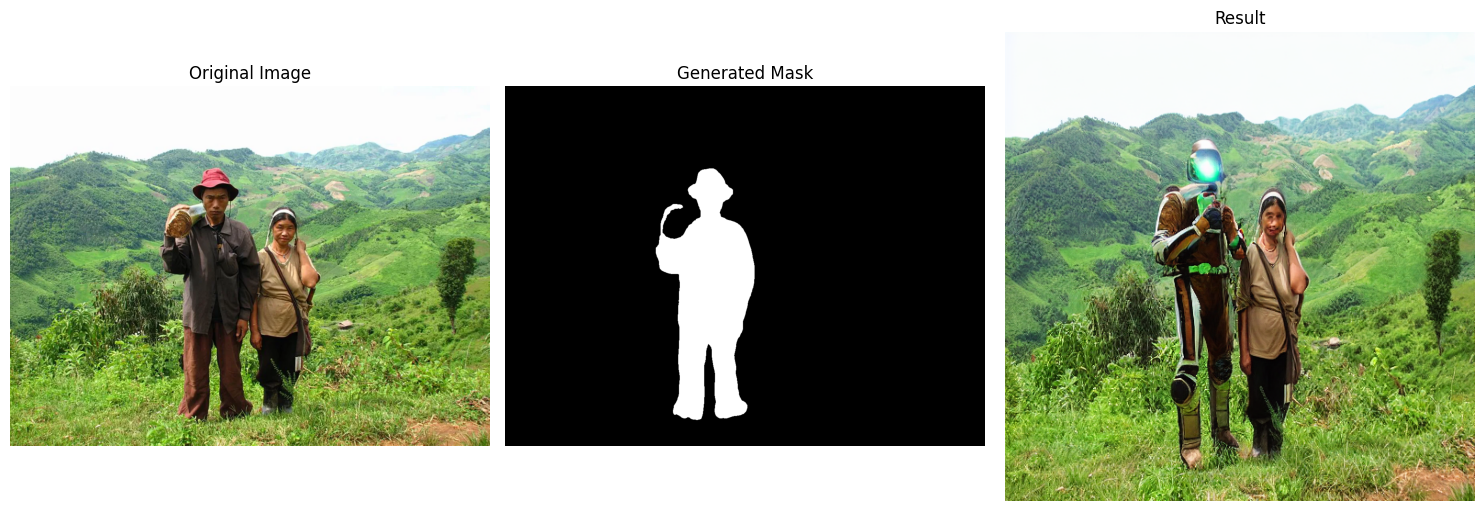

In [15]:
def main():
    # Loading the  models
    print("Loading models...")
    mask_generator = load_sam_model()
    sd_pipeline = load_sd_model()

    # Example usage
    image_url = "/content/akhacouple.webp"
    target_object = "person"  # THe Object to replace
    replacement_prompt = "Two people wearing spacesuits standing in a green mountainous landscape, high quality, detailed, realistic"

    # Process image
    original, mask, result = replace_object(
        image_url,
        target_object,
        replacement_prompt,
        sd_pipeline,
        mask_generator
    )

    # Display results
    display_results(original, mask, result)

if __name__ == "__main__":
    main()